# Counting Crowds with DL
## Proof Of Concept
The notebook will implement [Dense Scale Networks](https://arxiv.org/pdf/1906.09707.pdf) for the purpose of counting crowds for images.

## 1. Imports and loading the data.

In [1]:
import os
import pandas as pd
import numpy as np
import keras
import scipy
import scipy.io
import matplotlib.pyplot as plt
import glob
import h5py
from tqdm import tqdm
from PIL import Image
import keras.backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import mse, mae

import warnings  
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# reporting module
from ovreport.report import report_to_overwatch

### 1.1 Getting Data to Train the model.
A couple of datasets are available to use for the purpose of training. My goal is to try to combine them all and train the dense scale network on all of them and evaluate them on all tests set.

*NOTE*: Provide List of more famous Datasets

#### 1.1.1 UCF-QNRF_ECCV18

#### -- Exploring the data format and images

*TODO:* Learn images original size and aspect ratio.

In [3]:
ucf_qnrf_example = scipy.io.loadmat('training_dataset/UCF-QNRF_ECCV18/Train/img_0001_ann.mat')
print(ucf_qnrf_example.keys())
print(ucf_qnrf_example['annPoints'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'annPoints'])
(433, 2)


Judging from the keys of the example it seems, that the .mat files contain the annotation points. From the annotation points a density map will be generated, so that the model can be evaluated against it.

*TODO*: Explain why a k-nearest density map was chosen.

##### -- Density Map Generation
Below is an example of how a single density is created. For further information refer to the data_exploration notebook.

In [4]:
def gen_knk_density(image, points):
    image_h = image.shape[0]
    image_w = image.shape[1]

    # coordinate of heads in the image
    points_coordinate = points
    # quantity of heads in the image
    points_quantity = len(points_coordinate)

    # generate ground truth density map
    densitymap = np.zeros((image_h, image_w))
    if points_quantity == 0:
        return densitymap
    else:
        # build kdtree
        tree = scipy.spatial.KDTree(points_coordinate.copy(), leafsize=2048)
        # query kdtree
        distances, _ = tree.query(points_coordinate, k=4)
        for i, pt in enumerate(points_coordinate):
            pt2d = np.zeros((image_h,image_w), dtype=np.float32)
            
            if int(pt[1])<image_h and int(pt[0])<image_w:
                pt2d[int(pt[1]),int(pt[0])] = 1.

            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
            
            densitymap += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
        return densitymap

In [5]:
ucf_qnrf_ex_img = plt.imread('training_dataset/UCF-QNRF_ECCV18/Train/img_0001.jpg')

In [4]:
dens_map = gen_knk_density(ucf_qnrf_ex_img, ucf_qnrf_example['annPoints'])

In [ ]:
plt.imshow(dens_map)

In [ ]:
dens_map.shape

In [ ]:
plt.imshow(ucf_qnrf_ex_img)

In [ ]:
ucf_qnrf_ex_img.shape

In [ ]:
def build_dataframe(dataset_path):
    '''
        Gets the density/count vector by reading the .mat file 
        and getting the shape of the file. 
        The function only requires the path to the dataset.
    '''
    file_contents = os.listdir(dataset_path)
    only_mat_files = list(filter(lambda x: '.mat' in x, file_contents))
    
    densities = {'image_name':[], 'count': [], 'density': []}
    for mat in only_mat_files:
        filepath = os.path.join(dataset_path, mat)
        mat_loaded = scipy.io.loadmat(filepath)
        # we attach the .jpg at the end for the respective image
        image_name = mat.split('_a')[0] + '.jpg'
        densities['image_name'].append(image_name)
        densities['density'].append(mat_loaded['annPoints'])
        densities['count'].append(mat_loaded['annPoints'].shape[0])      
    
    # return it as a pandas dataframe
    return pd.DataFrame(densities)

In [ ]:
train_df = build_dataframe('training_dataset/UCF-QNRF_ECCV18/Train/')
test_df = build_dataframe('training_dataset/UCF-QNRF_ECCV18/Test/')

In [ ]:
train_df.head()

In [ ]:
test_df.head()

These densities have all been converted previously to a h5 file, along with the image data. The whole process is explained in the *Data_Exploration* notebook. Let me load a single one to detail the structure of one such file.

In [ ]:
sample_file = h5py.File('training_dataset/UCF-QNRF_ECCV18/Train_h5/img_0001.h5', 'r')

In [ ]:
sample_file.keys()

Verify that the count from the density_map and count align.

In [ ]:
tysample_file['count'].value, np.sum(sample_file['density_map'].value)

There is a difference, but in general they do.

#### -- Data Loading Aproaches

*NOTE:* Creating a master_df is not feasible, as pandas is memory consuming and I do only have 32GB, thus limiting the amount data such dataframe could hold. That is why the aproach will be looking into custom keras data loader to be able to serve this h5 files. I leave the code below just as an example that this is an option too, given enough ram.

In [ ]:
def build_master_df(dataset_path):
    '''
        Creates a dataset that contains for each row the name of the image, the image,
        represented as a numpy arrray, as well as the generated density map (the label).
        NOT 
    '''
    dir_contents = os.listdir(dataset_path)
    master_df = pd.DataFrame(columns=['name', 'image', 'density_map', 'count'])
    
    for i, file in tqdm(enumerate(dir_contents)):
        if '.h5' in file:
            current_file = h5py.File(os.path.join(dataset_path, file), 'r')
            # i could write a one liner to compile the row, but i opted out for code comprehension
            count = current_file['count'].value
            image = current_file['image_array'].value
            density_map = current_file['density_map'].value
            name = current_file['image_name'].value

            master_df.loc[i] = [name, image, density_map, count]
    
    return master_df

##### -- Custom Data Loader

In [3]:
class H5DataLoader:
    def __init__(self, filepath, batch_size=32, validation_split=None, resize=None, ratio=8, normalize=False):
        
        np.random.seed(42)
        
        self.ratio = ratio
        self.filepath = filepath
        self.files = sorted(glob.glob(os.path.join(filepath, '*.h5')))
        self.validation_split = validation_split
        self.batch_size = batch_size
        self.resize = resize
        self.normalize = normalize
        self.train_files = []
        self.validation_files = []
        
        if validation_split is not None:
            files_v = np.random.choice(self.files, int(self.validation_split * len(self.files)))
            self.validation_files = list(files_v)
            self.train_files = [file for file in self.files if file not in self.validation_files]
        else:
            self.train_files = self.files
    
    def __check_if_rgb(self, image):
        '''
            Checks if the image is RGB - if it is grayscale the image will have less than
            3 dimensions.
        '''
        if len(image.shape) < 3:
            return np.array(Image.fromarray(image).convert('RGB'))
        else:
            return image
        
    def __apply_resize(self, image):
        return np.array(Image.fromarray(image).resize(self.resize))
    
    def __apply_resize_by_ratio(self, image):
        return np.array(Image.fromarray(image).resize((self.resize[0] // self.ratio, self.resize[1] // self.ratio)))
    
    def __flip_dims(self, image):
        return np.reshape(image, (image.shape[1], image.shape[0], image.shape[2]))
        
    def __load_img_and_density(self, input_path):
        src_h5 = h5py.File(input_path, 'r')
        image = src_h5['image_array'].value
        output = src_h5['density_map'].value
        count = src_h5['count'].value
        
        return image, output, count
    
    def __normalize(self, arr):
        
        for i in range(3):
            maxval = arr[...,i].max()
            actual_value = 255.0 / maxval
            arr[...,i] *= int(actual_value)

        return arr
    
    def __apply_transformation(self, image):
        '''
            TODO: Implement Transformation
        '''
        transformed_image = image
        if self.normalize:
            transformed_image = self.__normalize(transformed_image)
        
        # TODO: chain other transformations
        
        return transformed_image
        
    
    def __flow(self, files, batch_size):
        while True:
            batch_paths = np.random.choice(files, batch_size)
            batch_input = []
            batch_output = []

            for input_path in batch_paths:
                
                input_img, output, count = self.__load_img_and_density(input_path)
                if self.resize is not None:
                    input_img = self.__apply_resize(input_img)
                    # check if image is rgb, if not convert it to one
                    input_img = self.__check_if_rgb(input_img)
                    # transform image if needed
                    input_img = self.__apply_transformation(input_img)
                    # flip dims
                    # input_img = self.__flip_dims(input_img)
                    
                    # first scale the output approriatly to the input
                    output = self.__apply_resize(output)
                    # then scale it again to match the network's output
                    output = self.__apply_resize_by_ratio(output)
                    # finally add the channel to the output
                    output = np.reshape(output, (output.shape + (-1,)))
                    # flip dims
                    # output = self.__flip_dims(output)
                
                batch_input += [input_img]
                batch_output += [output]

            batch_x = np.array(batch_input)
            batch_y = np.array(batch_output)

            yield (batch_x, batch_y) 
    
    def get_file_list(self):
        return self.files
    
    def training_flow(self):
        return self.__flow(self.train_files, batch_size=self.batch_size)
    
    def validation_flow(self):
        return self.__flow(self.validation_files, batch_size=1)

    def next(self):
        data = next(self.training_flow())
        return data
    
    def __len__(self):
        return len(self.files)

In [4]:
# GLOBAL PARAMETERS
train_batch_size = 1
test_batch_size = 1

aspect_ratio = 1.5
target_widgth = 720
target_height = int(target_widgth / aspect_ratio)

input_shape = (target_widgth, target_height)
print(input_shape)

(720, 480)


In data exploration notebook we saw that the median aspect ratio is 1.5, thus we need to resize accordingly. The paper recomends a batch size of 1, even during training.

##### -- Training & Validation [.h5]

In [5]:
train_h5_path = 'training_dataset/ShanghaiTech/train_h5/'
test_h5_path = 'training_dataset/ShanghaiTech/test_h5/'

In [6]:
train_gen = H5DataLoader(train_h5_path, \
                         train_batch_size, \
                         resize=input_shape, \
                         #validation_split=0.1, \
                         normalize=True)

Define the training itterators:

In [7]:
train_iter = train_gen.training_flow()
# valid_iter = train_gen.validation_flow()

##### -- Test [.h5]

In [8]:
test_gen = H5DataLoader(test_h5_path, \
                        test_batch_size, \
                        resize=input_shape)

In [9]:
test_iter = test_gen.training_flow()

#### Sample Training Image

In [10]:
x, y = train_gen.next()

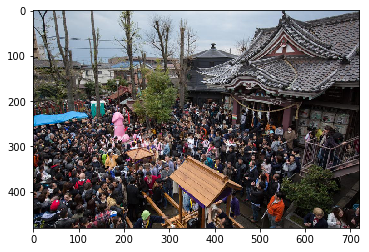

In [11]:
plt.imshow(x[0, :, :, :])
plt.show()

#### Sample Test Image

In [12]:
x, y = test_gen.next() 

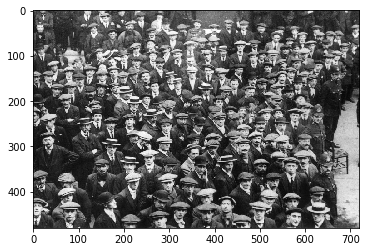

In [13]:
plt.imshow(x[0, :, :, :])
plt.show()

## 2. Building the Model
In order to build ithe Deep scale network first the Dense Dialated Convolution Block has to be implemented.

### 2.1 Network Architecture
*TODO*: Show pictures from paper

#### 2.1.0 Subclassing API Example
Had some issues with it so I will leave it here for a later point where I can revisit it.

In [14]:
class ConvBlock(keras.models.Model):
    '''
        TODO: Add Docstring
    '''
    def __init__(self, activation='relu', padding=1, dilation_rate=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(256, (1, 1), activation=activation)
        self.padding = keras.layers.ZeroPadding2D(padding=(padding, padding))
        self.conv2 = keras.layers.Conv2D(64, (3, 3), padding='valid', dilation_rate=dilation_rate, activation=activation)
    def call(self, inputs):
        out = self.conv1(inputs)
        out = self.padding(out)
        out = self.conv2(out)
        
        return out    

In [ ]:
class DDCB(keras.models.Model):
    '''
        TODO: Add Docstring
    '''
    def __init__(self, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.convBlock1 = ConvBlock(**kwargs)
        self.convBlock2 = ConvBlock(padding=2, dilation_rate=2, **kwargs)
        self.convBlock3 = ConvBlock(padding=3, dilation_rate=3, **kwargs)
        self.paddingOut = keras.layers.ZeroPadding2D(padding=(1,1))
        self.convOut = keras.layers.Conv2D(512, (3, 3), padding='valid', activation='relu')
    
    def call(inputs):
        out1 = self.convBlock1(inputs)
        out2 = keras.layers.Concatenate([inputs, out1])
        out3 = self.convBlock2(out2)
        out4 = keras.layers.Concatenate([inputs, out1, out3])
        out5 = self.convBlock3(out4)
        out6 = keras.layers.Concatenate([inputs, out3, out5])
        out7 = self.paddingOut(out6)
        out8 = self.convOut(out7)
        return out8 

In [ ]:
class DenseScaleNet(keras.models.Model):
    '''
        TODO: Add Docstring
    '''
    def __init__(self, model=None, input_shape=None, **kwargs):
        super().__init__(**kwargs)
        if model is None:
            if input_shape is None:
                raise Exception('A model could not have an input shape set to None.')
                
            model = self.__create_backbone(input_shape)
        
        self.model = model
        self.DDCB1 = DDCB(**kwargs)
        self.DDCB2 = DDCB(**kwargs)
        self.DDCB3 = DDCB(**kwargs)
        self.padding1 = keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv1 = keras.layers.Conv2D(128, (3, 3), padding='valid', activation='relu')
        self.padding2 = keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv2 = keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu')
        self.outconv = keras.layers.Conv2D(1, (1, 1), activation='relu')
    
    def __create_backbone(self, input_shape):
        '''
            TODO: Add Doctstring
        '''
        vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', input_shape=input_shape)
        model = keras.models.Sequential()
        
        # we want to copy the first ten layers from VGG16
        for layer in vgg16_model.layers[:11]:
            model.add(layer)
        
        return model
        
    def call(self, inputs):
        out1 = self.model(inputs)
        out2 = self.DDCB1(out1)
        out3 = out2 + out3
        out4 = self.DDCB2(out3)
        out5 = out4 + out2 + out1
        out6 = self.DDCB3(out5)
        out7 = out6 + out4 + out2 + out1
        out = self.padding1(out)
        out = self.conv1(out)
        out = self.padding2(out)
        out = self.conv2(out)
        out = self.outconv(out)
        
        return out           

#### 2.1.1 Functional API Implementation

In [15]:
def conv_block(x, activation='relu', padding=1, dilation_rate=1):
    '''
        TODO: Docstring
    '''
    x = keras.layers.Conv2D(256, (1, 1), padding='same', activation=activation)(x)
#     x = keras.layers.ZeroPadding2D(padding=(padding, padding))(x)
    out = keras.layers.Conv2D(64, (3, 3), padding='same', dilation_rate=dilation_rate, activation=activation)(x)
    
    return out

def ddcb(inputs):
    '''
        TODO: Docstring
    '''
    
    x1 = conv_block(inputs)
    x2 = keras.layers.concatenate([inputs, x1])
    x3 = conv_block(x2, padding=2, dilation_rate=2)
    x4 = keras.layers.concatenate([inputs, x1, x3])
    x5 = conv_block(x4, padding=3, dilation_rate=3)
    x6 = keras.layers.concatenate([inputs, x3, x5])
#     x7 = keras.layers.ZeroPadding2D(padding=(1,1))(x6)
    out = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x6)
    
    return out

In [16]:
class DenseScaleNetF:
    '''
        TODO: Docstring
    '''
    def __init__(self, input_shape, pretrained=False):
        self.input_shape = input_shape
        self.backbone = self.__create_backbone(input_shape, pretrained)
#         self.padding1 = keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv1 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
#         self.padding2 = keras.layers.ZeroPadding2D(padding=(1,1))
        self.conv2 = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')
        self.outconv = keras.layers.Conv2D(1, (1, 1), activation='relu')
    
    def __create_backbone(self, input_shape, pretrained):
        '''
            TODO: Add Doctstring
        '''
        weights = None
        if pretrained:
            weights = 'imagenet'
        
        vgg16_model = keras.applications.vgg16.VGG16(weights=weights, 
                                                     input_shape=input_shape,
                                                    include_top=False)
        model = keras.models.Sequential()
        
        # we want to copy the first ten layers from VGG16
        for i, layer in enumerate(vgg16_model.layers[:14]):
            model.add(layer)
            # add batch norm
            if i % 3 != 0:
                model.add(keras.layers.BatchNormalization())
        
        return model
    
    def build_model(self):
        '''
            TODO: Docstring
        '''
        
        # funny input names to be able to track input and output
        inputs = keras.layers.Input(shape=self.input_shape)
        bckb_x = self.backbone(inputs)
        ddcb1_x = ddcb(bckb_x)
        add1_x = keras.layers.add([ddcb1_x, bckb_x])
        ddcb2_x = ddcb(add1_x)
        add2_x = keras.layers.add([ddcb2_x, ddcb1_x, bckb_x])
        ddcb3_x = ddcb(add2_x)
        add3_x = keras.layers.add([ddcb3_x, ddcb2_x, ddcb1_x, bckb_x])
#         pad1_x = self.padding1(add3_x)
        conv1_x = self.conv1(add3_x)
#         pad2_x = self.padding2(conv1_x)
        conv2_x = self.conv2(conv1_x)
        out = self.outconv(conv2_x)
        # create the model
        model = keras.Model(inputs=inputs, outputs=out)
        
        return model

In [17]:
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', 
                                             input_shape=(224, 224, 3),
                                            include_top=False)

### 2.2 Neccessary Callbacks

In [19]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.mae_logs = []
        self.mse_logs = []

    def set_dataset_length(self, ds_lenght):
        self.dslength = ds_lenght    
    
    def on_epoch_begin(self, epoch, logs={}):
        self.acutal_mae = 0
        self.actual_mse = 0
        self.sum_mae = 0
        self.sum_mse = 0        
    
    def on_batch_end(self, batch, logs={}):
        # update the metrics
        if logs.get('mae') is None:
            current_mae = 0
            current_mse = 0
        else:
            current_mae = logs.get('mae')
            current_mse = logs.get('mse')

        self.sum_mae += current_mae
        self.sum_mse += current_mse
        # update the actual metrics
        self.actual_mae = self.sum_mae #/ (logs.get('batch') + 1)
        self.actual_mse = self.sum_mse #/ (logs.get('batch') + 1)
        # print the results
        
        # finally append the logs, just for safe keeping
        self.loss.append(logs.get('loss'))
        self.mae_logs.append(logs.get('mae'))
        self.mse_logs.append(logs.get('mse'))
    
    def on_epoch_end(self, epoch, logs={}):
        agg_mae = self.sum_mae / self.dslength
        agg_mse = self.sum_mse / self.dslength
        print(f'Aggregated: {round(agg_mae, 4)}, {round(agg_mse, 4)}')
        

In [20]:
history = LossHistory()
history.set_dataset_length(len(train_gen))

In [21]:
# Checkpoints
checkpoint = keras.callbacks.ModelCheckpoint(filepath='models/tf/best/weights.{mae:02f}-{epoch:02d}.hdf5', 
                                             monitor='mae',
                                             verbose=1,
                                             save_best_only=False,
                                             mode='min',
                                             period=1
                                            )

class BestCheckPoint(keras.callbacks.ModelCheckpoint):
    def __init__(self, best_init=None, *arg, **kwagrs):
        super().__init__(*arg, **kwagrs)
        if best_init is not None:
            self.best = best_init


best_checkpoint = BestCheckPoint(filepath='models/tf/best/sgh_weights_best.h5',
                                 best_init=9999,
                                 monitor='mae',
                                 verbose=1,
                                 save_best_only=True
                                )            

# Tensorboard
tensorboard = keras.callbacks.TensorBoard(
    log_dir='log/',
    write_graph=True,
    batch_size=train_batch_size,
    write_images=True,
    update_freq='batch'
)

In [22]:
calback_list = [
    checkpoint,
    best_checkpoint,
    tensorboard,
    history
]

### 2.3 The Optimizer
The paper uses an Adam optimizer with a learning rate of 5e-6.
-- add weight decay.

In [23]:
optimizer = keras.optimizers.Adam(lr=1e-4)

#### 2.3.1 Adding L2 Penalty
As the original paper uses L2 regularization of the cost function to assist with model convergence I will leave it as an option.

In [24]:
def add_l2_reg(model, weight_decay):
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            layer.kernel_regularizer=keras.regularizers.l2(weight_decay)
    
    return model

In [25]:
weight_decay = 5e-4

### 2.4 Custom Loss

**TODO:** Explanation for the custom loss from the paper

In [26]:
def euclidean_distance_loss(y_true, y_pred):
    '''
        Euclidean distance loss
        https://en.wikipedia.org/wiki/Euclidean_distance
    '''
    return K.sqrt(K.sum(K.square(y_pred - y_true)))

def average_pooling(input_tensor, shape):
    '''
        Pooling the input_layer according to the output size.
    '''
    
    # 8 is the factor with which the model scales the input image
    pool_shape_x = input_shape[1] // 8 // shape 
    pool_shape_y = input_shape[0] // 8 // shape

    pool_shape = (pool_shape_x, pool_shape_y)
    pool = K.pool2d(input_tensor, pool_shape, strides=pool_shape, pool_mode='avg')
    
    return pool
    
def mean_abs_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))
    
def multiscale_dens_scale_loss(y_true, y_pred):
    '''
        Calculate the multiscale density loss as defined in the paper.
    '''
    loss = 0
    for i in [1, 2, 4]:
        pool_y_true = average_pooling(y_true, i)
        pool_y_pred = average_pooling(y_pred, i)
        loss += mean_abs_error(pool_y_true, pool_y_pred)
        
    return loss
    
    
def dsn_loss(y_true, y_pred):
    Le = euclidean_distance_loss(y_true, y_pred)
    Lc = multiscale_dens_scale_loss(y_true, y_pred)
    lambd = 1000 # coming straight from the paper for the UCF dataset will move it to a global
    return Le + lambd * Lc

### 2.5 Custom Metrics
Nothing out of the ordinary - just the metrics have to be evaluated on the count, not on the density maps themselves.

In [27]:
def mae(y_true, y_pred):
    return K.abs(K.sum(y_pred) - K.sum(y_true))

def mse(y_true, y_pred):
    return K.square(K.sum(y_pred) - K.sum(y_true))

### 2.6 Model Compilation & Summary

In [28]:
if os.path.exists('checkpoints/best/weights_best.h5'):
    dsn_model = keras.models.load_model('checkpoints/best/weights_best.h5', custom_objects={'dsn_loss': dsn_loss,
                                                                                           'mae': mae,
                                                                                           'mse': mse})
else:
    dsn_model = DenseScaleNetF(input_shape=(input_shape[1], input_shape[0], 3), 
                               pretrained=False)
    dsn_model = dsn_model.build_model()
    dsn_model.compile(loss=dsn_loss,
                     optimizer=optimizer,
                     metrics=[mae, mse])
    dsn_model.summary()




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 480, 720, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 60, 90, 512)  7643968     input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 60, 90, 256)  131328      sequential_1[1][0]               
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 60, 90, 64)   147520      conv2d_4[0][0]                   
__________________________________________________________________________________________________
concate

In [29]:
# add reg
dsn_model = add_l2_reg(dsn_model, weight_decay)

### 2.7 Fitting the model to the data.

In [30]:
# training_steps = (0.9 * len(train_gen)) // train_batch_size
# validation_steps = int(0.1 * len(train_gen))
training_steps = len(train_gen) // train_batch_size

In [ ]:
dsn_model.fit_generator(train_iter,
                       steps_per_epoch = training_steps,
                       epochs = 5,
                       callbacks=calback_list
                       )
report_to_overwatch('PH:ML:P', 'Atlas', 'Training of model done!')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
400/400 [==============================] - 132s 329ms/step - loss: 4.9109 - mae: 8.3247 - mse: 11107.4480

Epoch 00001: saving model to models/tf/best/weights.8.324700-01.hdf5

Epoch 00001: mae improved from 9999.00000 to 8.32470, saving model to models/tf/best/sgh_weights_best.h5
Aggregated: 8.3247, 11107.448
Epoch 2/5
400/400 [==============================] - 127s 319ms/step - loss: 2.1291 - mae: 3.5878 - mse: 40.4251

Epoch 00002: saving model to models/tf/best/weights.3.587787-02.hdf5

Epoch 00002: mae improved from 8.32470 to 3.58779, saving model to models/tf/best/sgh_weights_best.h5
Aggregated: 3.5878, 40.4251
Epoch 3/5
400/400 [==============================] - 128s 319ms/step - loss: 1.5894 - mae: 2.6761 - mse: 26.3289

Epoch 00003: saving model to models/tf/best/weights.2.676117-03.hdf5

Epoch 00003: mae improved from 3.58779 to 2.67612, saving model to models/tf/best/sg

### 2.8 Model Evaluation

#### 2.8.1 Load the Best Model

In [ ]:
dsn_model = keras.models.load_model('models/tf/best/weights.6.672973-01.hdf5', custom_objects={'dsn_loss': dsn_loss,
                                                                                           'mae': mae,
                                                                                           'mse': mse})

#### 2.8.2 Evaluate

I still get totally different results from the ones on the paper... Have to look at those loss functions.

In [30]:
predictions = dsn_model.predict_generator(test_iter, steps=len(test_gen), verbose=1)

316/316 [==============================] - 28s 87ms/step


In [33]:
np.sum(predictions[6])

0.0